In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

In [2]:
def smooth_data(data, window_size=5):
    """Smooth data using a moving average."""
    return uniform_filter1d(data, size=window_size, mode='nearest')

def plot_radiation(ground_truth_intensity, predicted_intensity=None, frequency_range=512, t=1000, gpu_box=0, path='',
                   enable_wandb=False):
    """
    Plot radiation intensity against frequency and compute MSE and relative MSE
    between ground truth and prediction. Compatible with both NumPy arrays and PyTorch tensors.

    Parameters:
    - ground_truth_intensity: A tensor or array of ground truth radiation spectra values.
    - predicted_intensity: A tensor or array of predicted radiation spectra values (optional).
    - t: Time step for the title (default=1000).
    - gpu_box: Identifier for the GPU box (default=0).
    - path: Path to save the plot (optional).
    - enable_wandb: Enable logging to Weights & Biases (default=False).
    """
    
    import numpy as np
    import matplotlib.pyplot as plt

    def to_numpy(data):
        """Convert PyTorch tensor to NumPy array if necessary."""
        if 'torch' in str(type(data)):
            return data.cpu().numpy()
        return data

    # Load frequency data
    frequency = np.load("/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/omega.npy")[:frequency_range]
    
    # Ensure ground_truth_intensity and predicted_intensity are NumPy arrays
    ground_truth_intensity = to_numpy(ground_truth_intensity)[:frequency_range]
    ground_truth_smoothed = smooth_data(ground_truth_intensity)
    
    plt.figure(figsize=(10, 6))
    plt.plot(frequency, ground_truth_intensity, label='GT Radiation Intensity (Raw)', color='blue', linewidth=2)
    
    mse, rel_mse = 0, 0  # Initialize MSE and Relative MSE
    
    if predicted_intensity is not None:
        predicted_intensity = to_numpy(predicted_intensity)[:frequency_range]
        predicted_smoothed = smooth_data(predicted_intensity)
        
        plt.plot(frequency, predicted_smoothed, label='Predicted Radiation Intensity (Smoothed)', linestyle='--', color='red', marker='o', markersize=5, zorder=1)
        plt.plot(frequency, predicted_intensity, label='Predicted Radiation Intensity (Raw)', linestyle='--', color='red', alpha=0.3, zorder=0, markersize=3)
        plt.xscale("log")
        
        # Compute MSE
        mse = np.mean((ground_truth_intensity - predicted_intensity) ** 2)
        
        # Compute Relative MSE
        rel_mse = mse / np.mean(ground_truth_intensity ** 2)
    
    # Update plot title with MSE and Relative MSE if prediction is provided
    if predicted_intensity is not None:
        plt.title(f'Radiation Intensity vs. Frequency t = {t}, box = {gpu_box}\nMSE = {mse:.2e}, Relative MSE = {rel_mse:.2e}')
    else:
        plt.title(f'Radiation Intensity vs. Frequency t = {t}, box = {gpu_box}')
    
    plt.xlabel('Frequency')
    plt.ylabel('Intensity (log scale)')
    plt.legend()
    plt.grid(True)
    
    if path:
        plt.savefig(f'{path}/radiation_plots_{t}_{gpu_box}.png')
    
    if enable_wandb:
        import wandb
        wandb.log({"Radiation (t={},box={})".format(t, gpu_box): wandb.Image(plt)})
        plt.close()
    else:
        plt.show()


def create_momentum_density_plots(px, py, pz,
                                  px_pr, py_pr, pz_pr,
                                  px_pr_ae, py_pr_ae, pz_pr_ae,
                                  chamfers_loss=None,emd_loss=None,
                                  bins=100, t=1000, gpu_box =0, path='',
                                  enable_wandb = False):
    
    # Specify the number of bins for each axis
    bins_px = np.linspace(min(px), max(px), bins)
    bins_py = np.linspace(min(py), max(py), bins)
    bins_pz = np.linspace(min(pz), max(pz), bins)
    
    loss_info = ''
    if chamfers_loss is not None:
        loss_info += '\nChamfers: {:.4f}'.format(chamfers_loss)
    if emd_loss is not None:
        loss_info += '\nEMD: {:.4f}'.format(emd_loss)
    
    # Create subplots for each plane
    plt.figure(figsize=(15, 15)) 
    
    # px-py Plane Ground Truth
    plt.subplot(331)
    plt.hist2d(px, py, bins=[bins_px, bins_py], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('px')
    plt.ylabel('py')
    plt.title('px-py GT at t = {}, box = {}'.format(t,gpu_box))
    
    # px-pz Plane Ground Truth
    plt.subplot(332)
    plt.hist2d(px, pz, bins=[bins_px, bins_pz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('px')
    plt.ylabel('pz')
    plt.title('px-pz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # py-pz Plane Ground Truth
    plt.subplot(333)
    plt.hist2d(py, pz, bins=[bins_py, bins_pz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('py')
    plt.ylabel('pz')
    plt.title('py-pz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # px-py Plane Prediction
    plt.subplot(334)
    plt.hist2d(px_pr, py_pr, bins=[bins_px, bins_py], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('py_pr')
    plt.title('px-py INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # px-pz Plane Prediction
    plt.subplot(335)
    plt.hist2d(px_pr, pz_pr, bins=[bins_px, bins_pz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('pz_pr')
    plt.title('px-pz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # py-pz Plane Prediction
    plt.subplot(336)
    plt.hist2d(py_pr, pz_pr, bins=[bins_py, bins_pz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('py_pr')
    plt.ylabel('pz_pr')
    plt.title('py-pz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # px-py Plane Prediction
    plt.subplot(337)
    plt.hist2d(px_pr_ae, py_pr_ae, bins=[bins_px, bins_py], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('py_pr')
    plt.title('px-py AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # px-pz Plane Prediction
    plt.subplot(338)
    plt.hist2d(px_pr_ae, pz_pr_ae, bins=[bins_px, bins_pz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('pz_pr')
    plt.title('px-pz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # py-pz Plane Prediction
    plt.subplot(339)
    plt.hist2d(py_pr_ae, pz_pr_ae, bins=[bins_py, bins_pz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('py_pr')
    plt.ylabel('pz_pr')
    plt.title('py-pz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    plt.tight_layout()
    
    # Save the plots as image files
    if path:
        plt.savefig(path + '/momentum_density_plots_{}_{}.png'.format(t,gpu_box))
    
    if enable_wandb == True:
        # Log the overlapping histogram plot
        wandb.log({"Px vs Py vs Pz histograms (t={},box={})".format(t,gpu_box): wandb.Image(plt)})

        plt.close()
    else:
        plt.show()   


def create_force_density_plots(fx, fy, fz,
                               fx_pr, fy_pr, fz_pr,
                               fx_pr_ae, fy_pr_ae, fz_pr_ae,
                               chamfers_loss=None,emd_loss=None,
                               bins=100, t=1000, gpu_box =0, path='',
                               enable_wandb = False):
    
    # Specify the number of bins for each axis
    bins_fx = np.linspace(min(fx), max(fx), bins)
    bins_fy = np.linspace(min(fy), max(fy), bins)
    bins_fz = np.linspace(min(fz), max(fz), bins)
    
    loss_info = ''
    if chamfers_loss is not None:
        loss_info += '\nChamfers: {:.4f}'.format(chamfers_loss)
    if emd_loss is not None:
        loss_info += '\nEMD: {:.4f}'.format(emd_loss)
        
    # Create subplots for each plane
    plt.figure(figsize=(15, 15))  # Adjust the figure size
    
    # fx-fy Plane Ground Truth
    plt.subplot(331)
    plt.hist2d(fx, fy, bins=[bins_fx, bins_fy], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('fx')
    plt.ylabel('fy')
    plt.title('fx-fy GT at t = {}, box = {}'.format(t,gpu_box))
    
    # fx-fz Plane Ground Truth
    plt.subplot(332)
    plt.hist2d(fx, fz, bins=[bins_fx, bins_fz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('fx')
    plt.ylabel('fz')
    plt.title('fx-fz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # fy-fz Plane Ground Truth
    plt.subplot(333)
    plt.hist2d(fy, fz, bins=[bins_fy, bins_fz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('fy')
    plt.ylabel('fz')
    plt.title('fy-fz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # fx-fy Plane Prediction
    plt.subplot(334)
    plt.hist2d(fx_pr, fy_pr, bins=[bins_fx, bins_fy], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fy_pr')
    plt.title('fx-fy INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fx-fz Plane Prediction
    plt.subplot(335)
    plt.hist2d(fx_pr, fz_pr, bins=[bins_fx, bins_fz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fz_pr')
    plt.title('fx-fz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fy-fz Plane Prediction
    plt.subplot(336)
    plt.hist2d(fy_pr, fz_pr, bins=[bins_fy, bins_fz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('fy_pr')
    plt.ylabel('fz_pr')
    plt.title('fy-fz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fx-fy Plane Prediction
    plt.subplot(337)
    plt.hist2d(fx_pr_ae, fy_pr_ae, bins=[bins_fx, bins_fy], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fy_pr')
    plt.title('fx-fy AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fx-fz Plane Prediction
    plt.subplot(338)
    plt.hist2d(fx_pr_ae, fz_pr_ae, bins=[bins_fx, bins_fz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fz_pr')
    plt.title('fx-fz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fy-fz Plane Prediction
    plt.subplot(339)
    plt.hist2d(fy_pr_ae, fz_pr_ae, bins=[bins_fy, bins_fz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('fy_pr')
    plt.ylabel('fz_pr')
    plt.title('fy-fz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    plt.tight_layout()
    
    # Save the plots as image files
    if path:
        plt.savefig(path + '/force_density_plots_{}_{}.png'.format(t,gpu_box))
    
    if enable_wandb == True:
        # Log the overlapping histogram plot
        wandb.log({"Fx vs Fy vs FZ histograms (t={},box={})".format(t,gpu_box): wandb.Image(plt)})

        plt.close()
    else:
        plt.show()          
        


def extract_components(p_gt,pc_pr,pc_pr_ae):

    # Visualization code for momentum
    px = p_gt[:, 0]  # Px component of momentum for GT
    py = p_gt[:, 1]  # Py component of momentum for GT
    pz = p_gt[:, 2]  # Pz component of momentum for GT

    px_pr = pc_pr[:, 0]  # Px component of momentum for INN-VAE
    py_pr = pc_pr[:, 1]  # Py component of momentum for INN-VAE
    pz_pr = pc_pr[:, 2]  # Pz component of momentum for INN-VAE

    px_pr_ae = pc_pr_ae[:, 0]  # Px component of momentum for VAE
    py_pr_ae = pc_pr_ae[:, 1]  # Py component of momentum for VAE
    pz_pr_ae = pc_pr_ae[:, 2]  # Pz component of momentum for VAE

    # Visualization code for force
    fx = p_gt[:, 3]  # Fx component of force for GT
    fy = p_gt[:, 4]  # Fy component of force for GT
    fz = p_gt[:, 5]  # Fz component of force for GT

    fx_pr = pc_pr[:, 3]  # Fx component of force for INN-VAE
    fy_pr = pc_pr[:, 4]  # Fy component of force for INN-VAE
    fz_pr = pc_pr[:, 5]  # Fz component of force for INN-VAE

    fx_pr_ae = pc_pr_ae[:, 3]  # Fx component of force for VAE
    fy_pr_ae = pc_pr_ae[:, 4]  # Fy component of force for VAE
    fz_pr_ae = pc_pr_ae[:, 5]  # Fz component of force for VAE
    
    create_momentum_density_plots(px, py, pz,
                          px_pr, py_pr, pz_pr,
                          px_pr_ae, py_pr_ae, pz_pr_ae,     
                          bins=100, t=t_index, gpu_box=gpu_index,
                          enable_wandb = False
                         ) 

    create_force_density_plots(fx, fy, fz,
                       fx_pr, fy_pr, fz_pr,
                       fx_pr_ae, fy_pr_ae, fz_pr_ae,     
                       bins=100, t=t_index, gpu_box=gpu_index,
                       enable_wandb = False
                      )


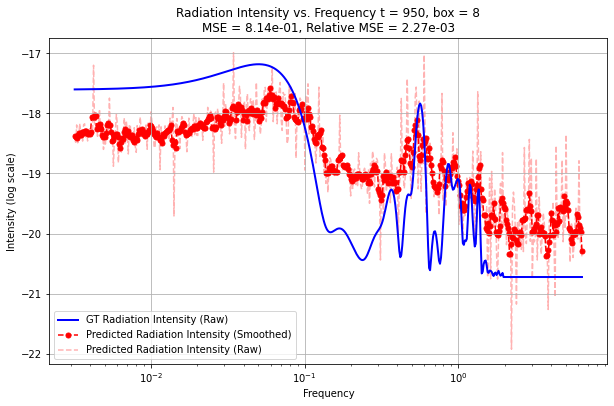

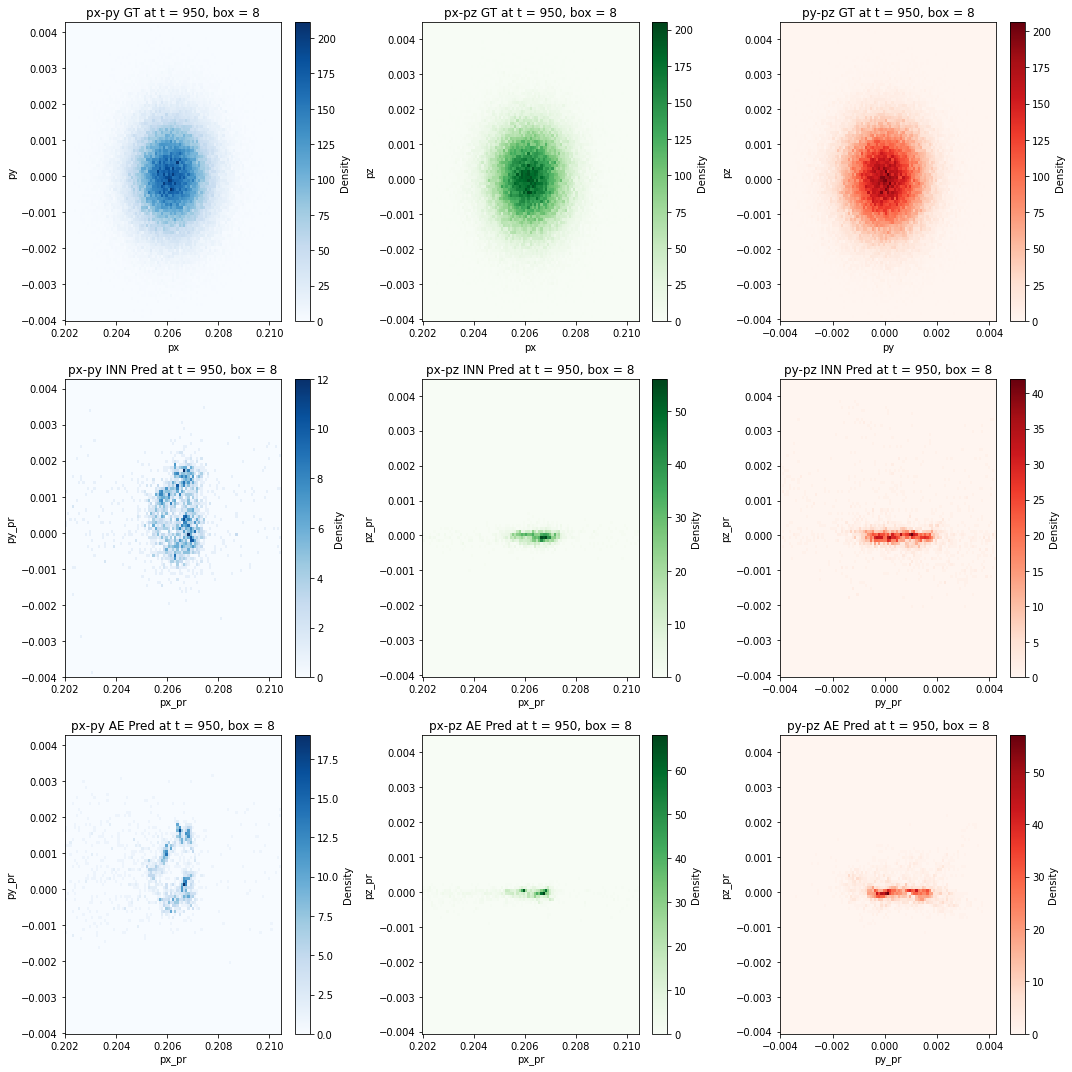

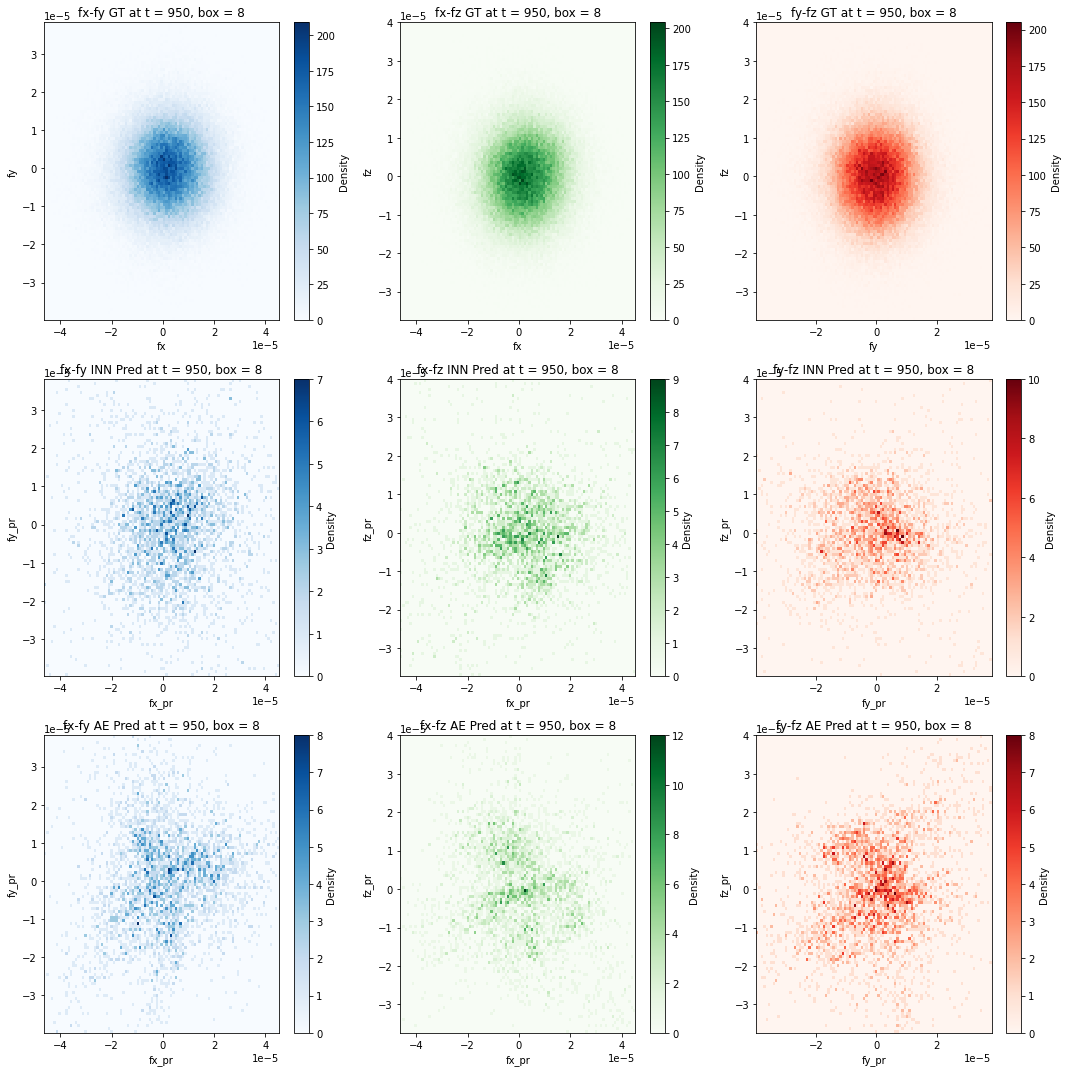

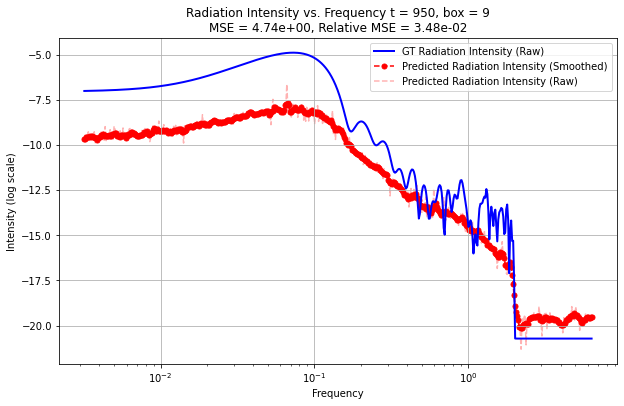

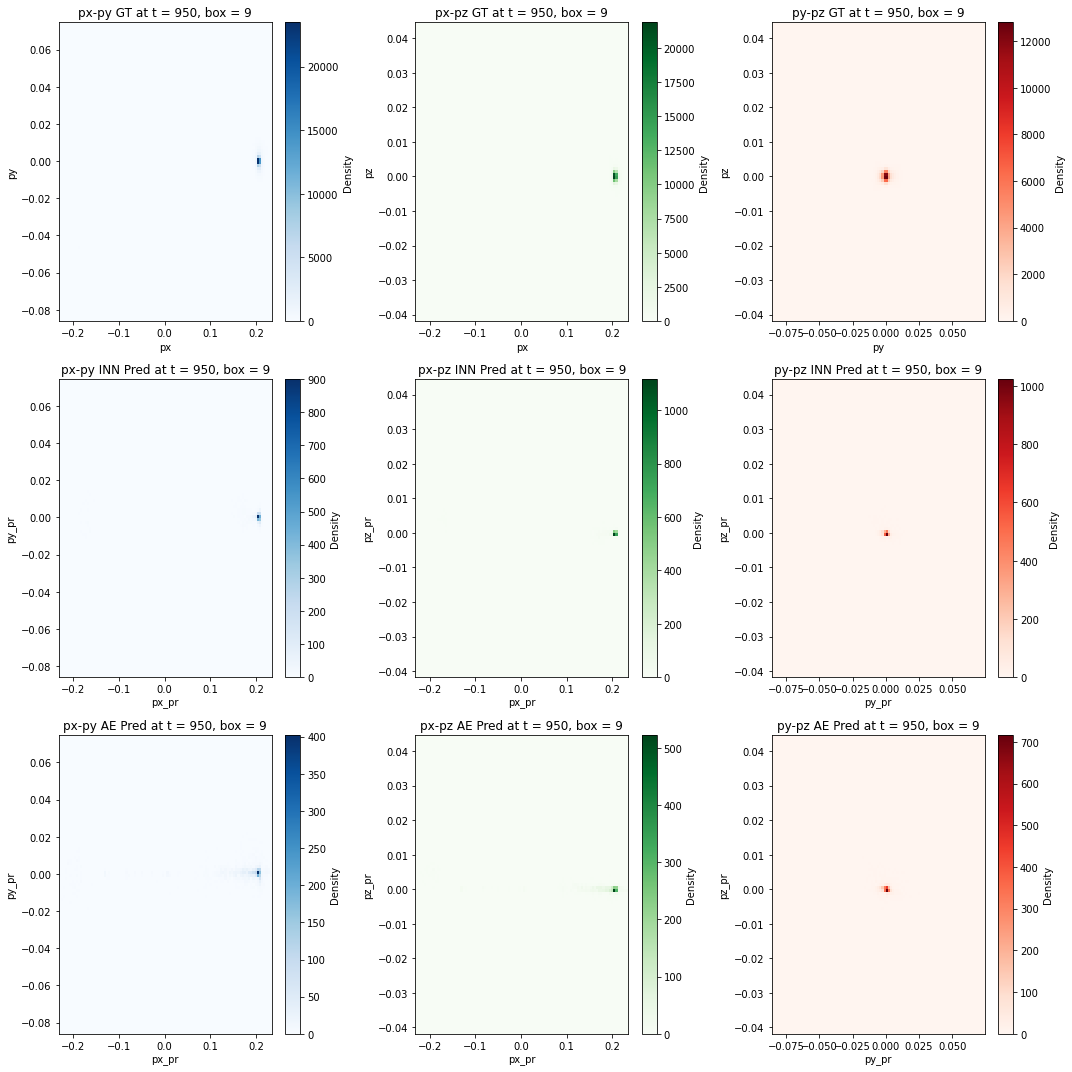

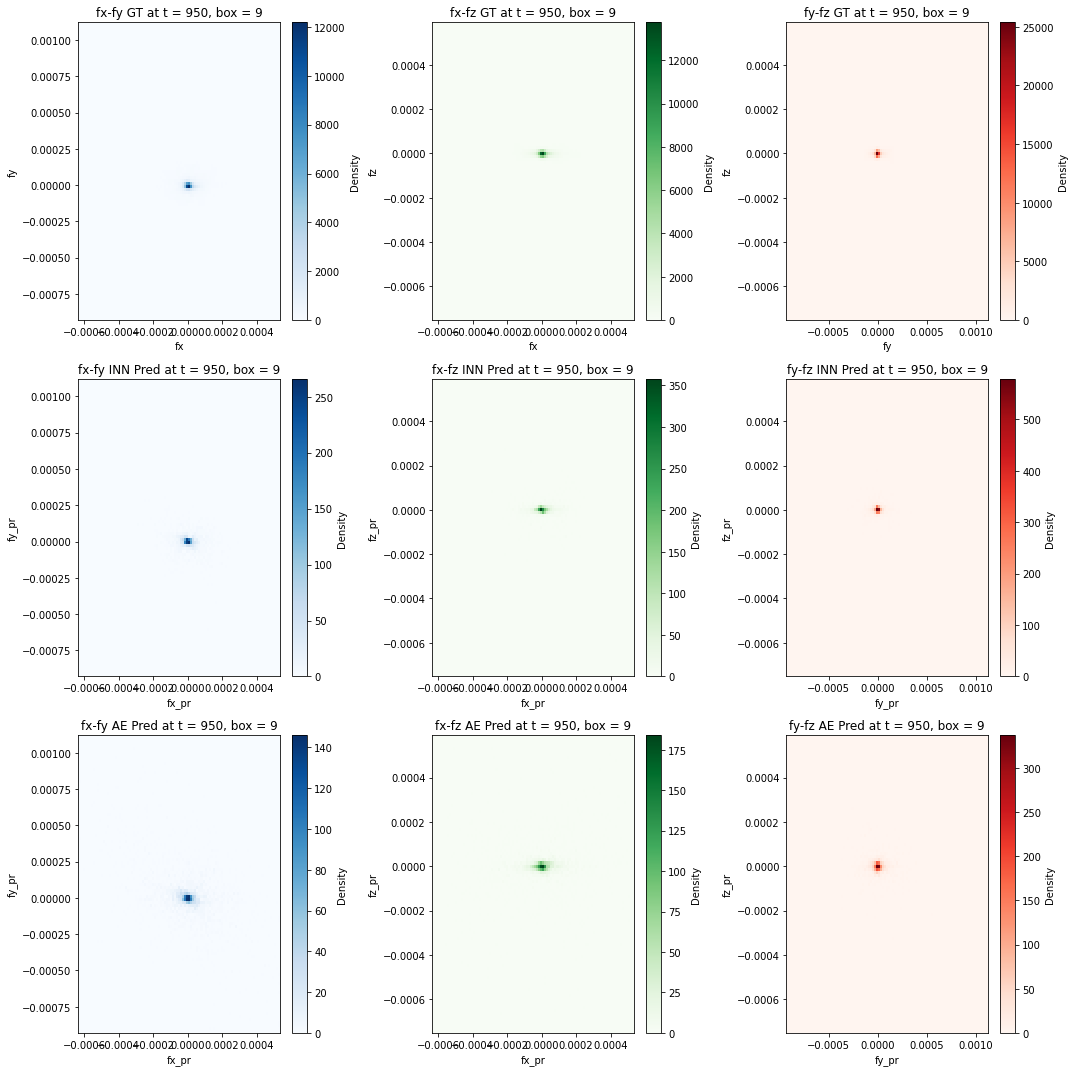

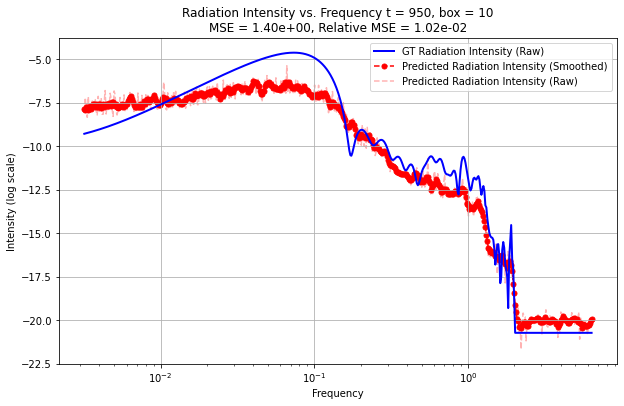

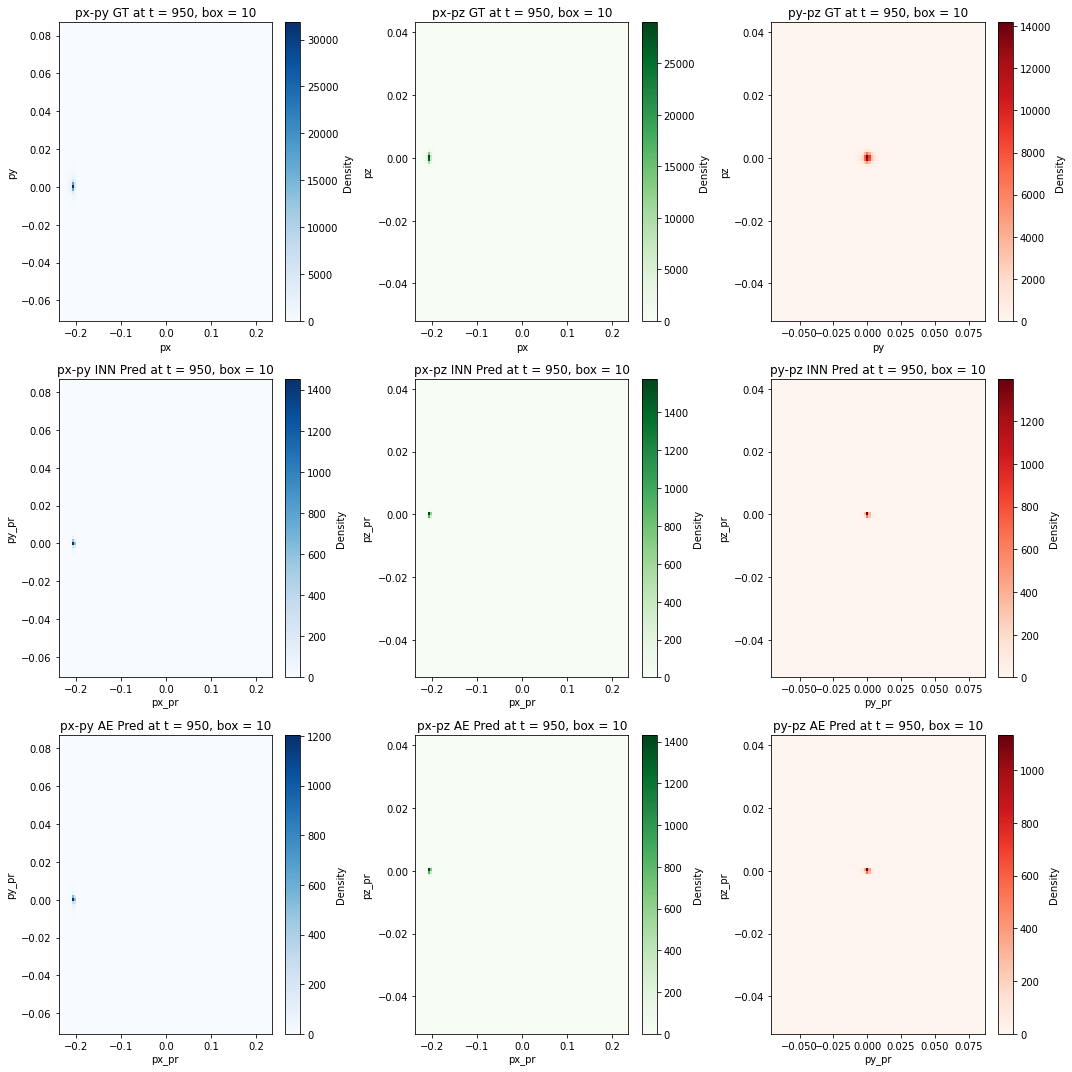

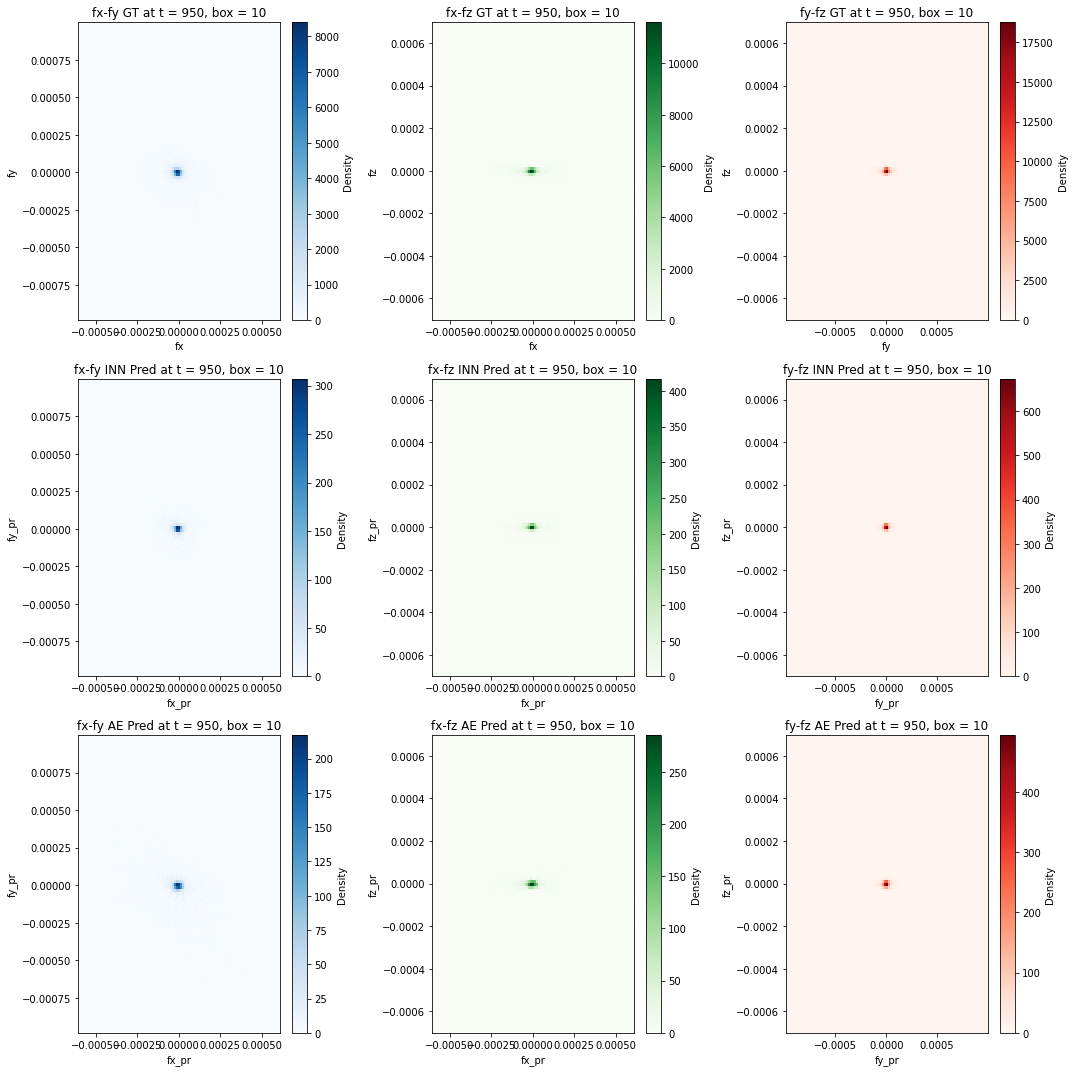

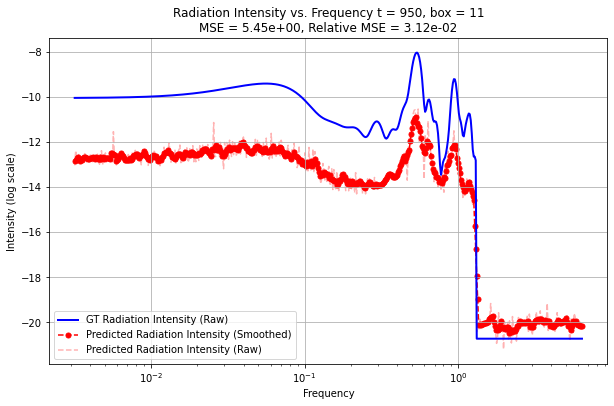

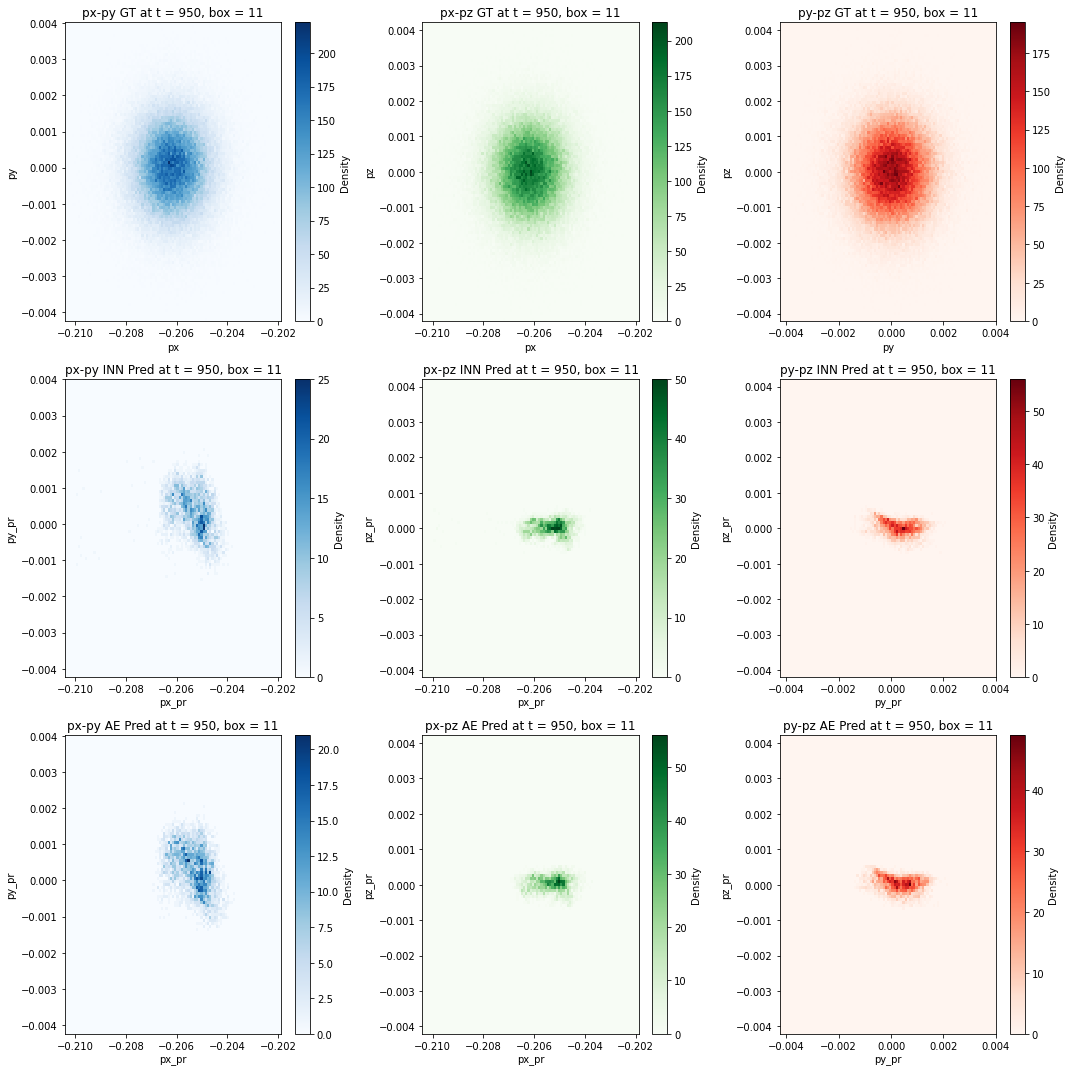

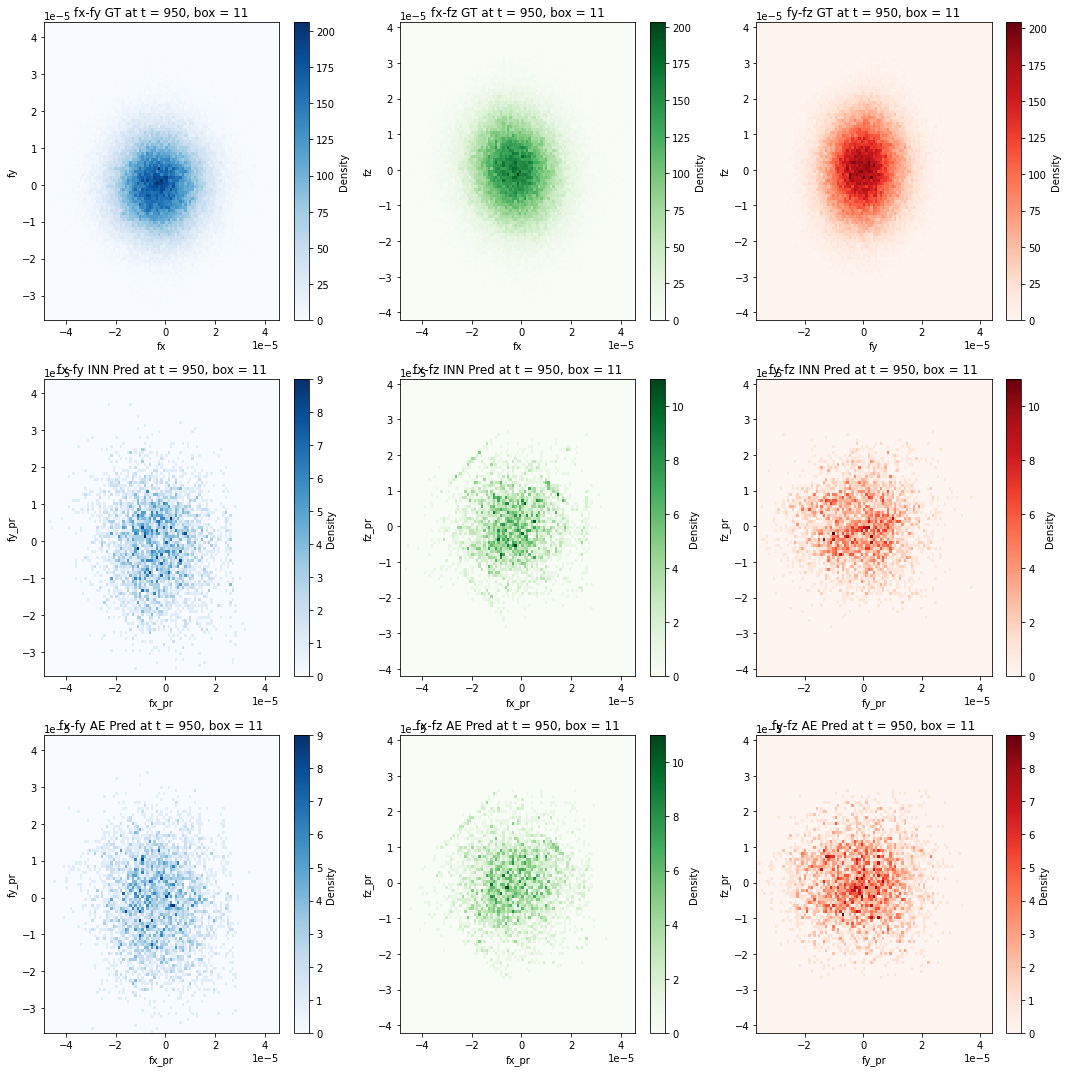

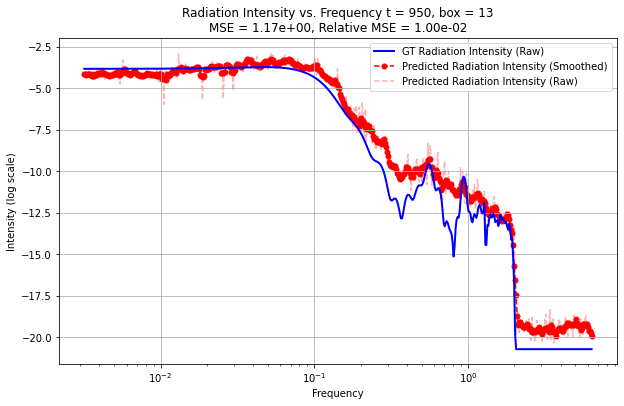

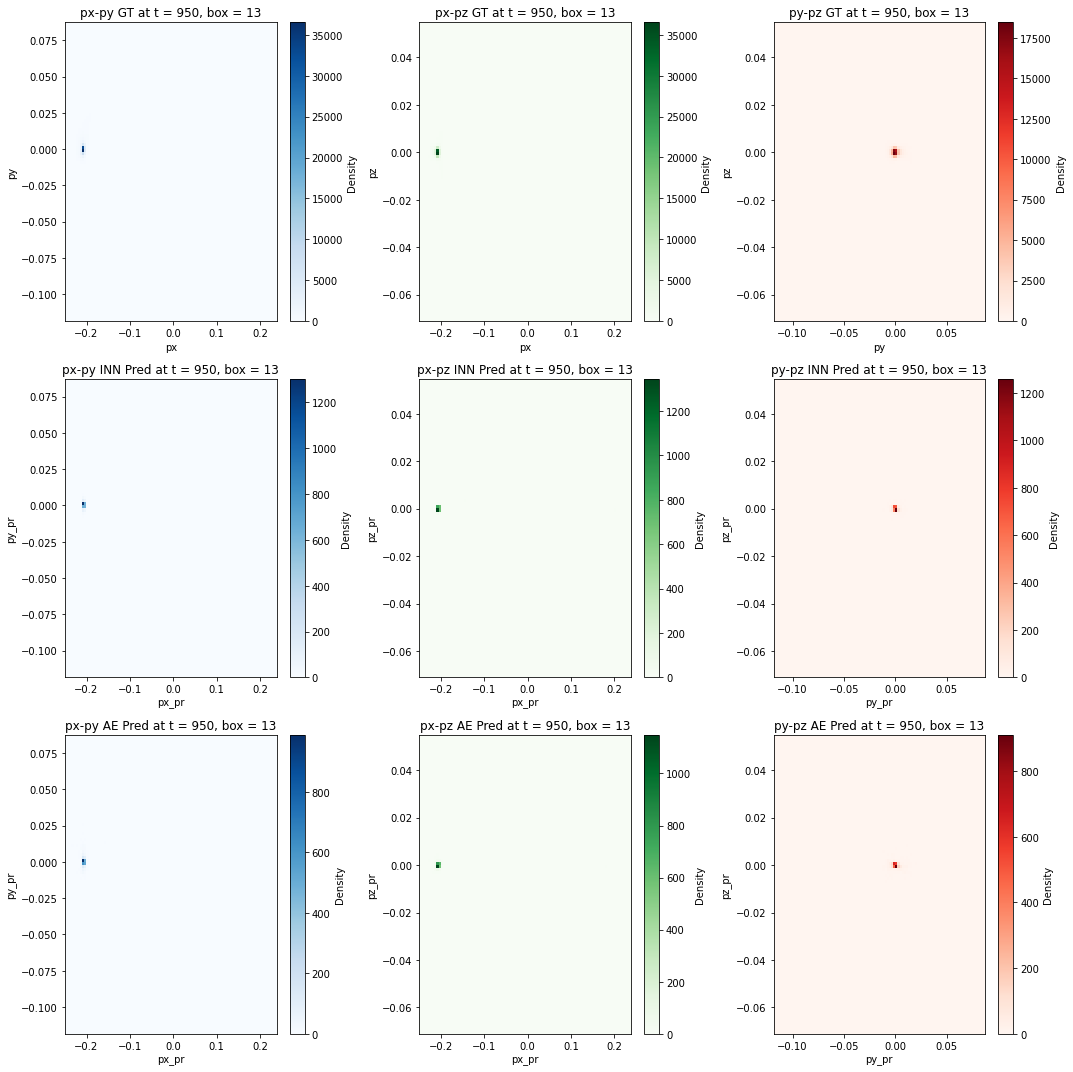

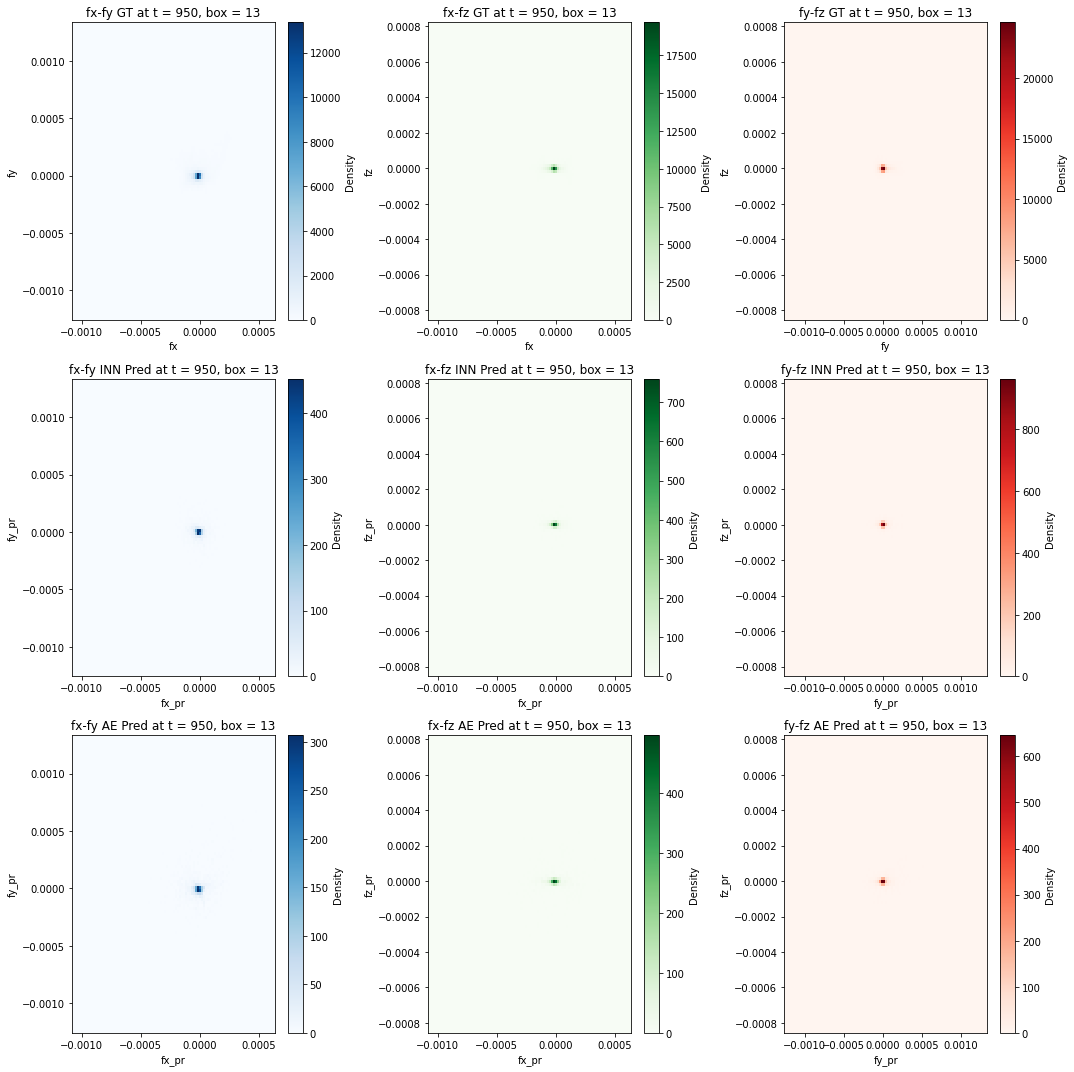

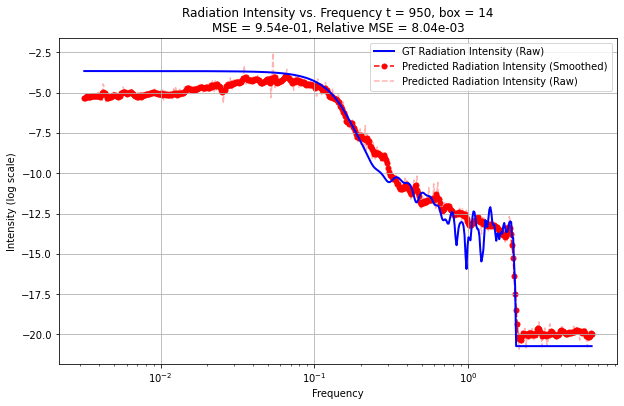

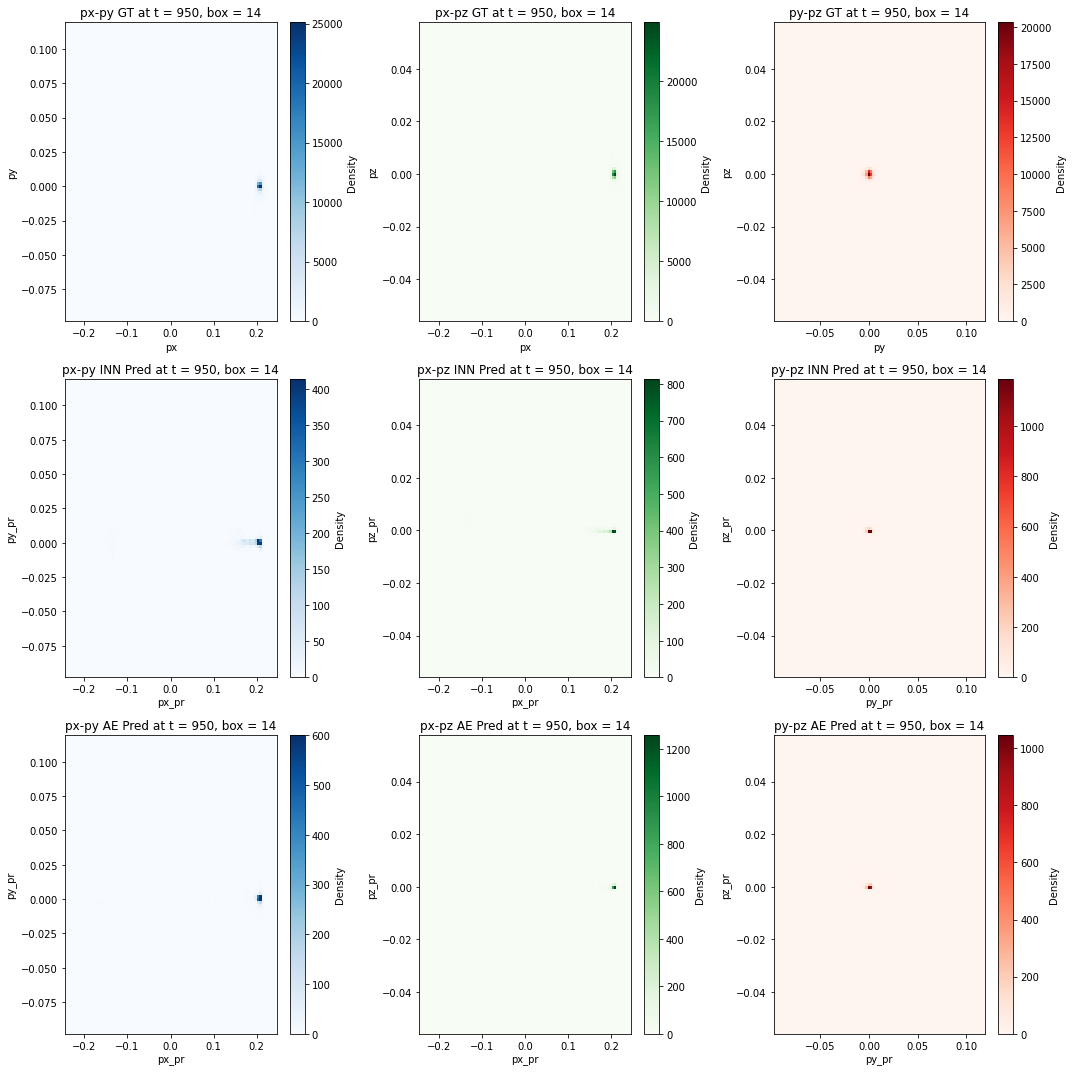

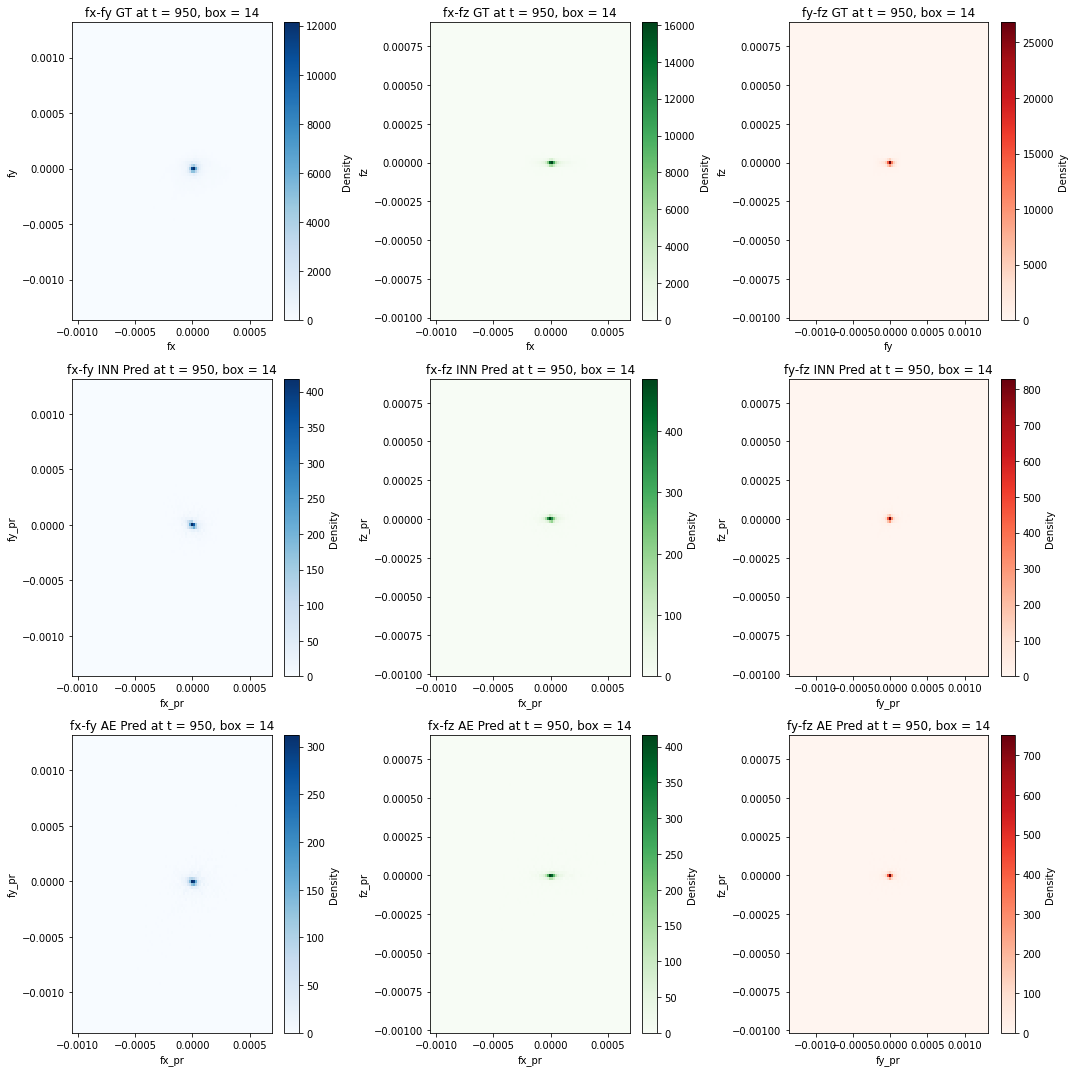

In [3]:
# +x stream data --> 8
# -x stream data --> 11
# vortex with mainly +x stream --> 9,14
# vortex with mainly -x stream --> 10,13

gpu_indexes = [8, 9, 10, 11, 13, 14]
t_index = 950

for gpu_index in gpu_indexes:

    filename = f'data_gpu_{gpu_index}_tindex_{t_index}.npz'
    
    # Load the data for the current GPU box
    with np.load(filename) as data:
        rad_gt = data['rad_gt'] # radiation GT
        rad_pred = data['rad_pred'] # radiation prediction
        ps_gt = data['ps_gt'] # phase space GT
        ps_pr_inn = data['ps_pr_inn'] # phase space INN-VAE prediction
        ps_pr_ae = data['ps_pr_ae'] # phase space VAE prediction
    
    plot_radiation(ground_truth_intensity=rad_gt, predicted_intensity=rad_pred, t=t_index, gpu_box=gpu_index, enable_wandb=False)
    
    extract_components(ps_gt, ps_pr_inn, ps_pr_ae)